Starting figure generation, reading data: ../../results/05_p_m_a_model/a_model_4/LSTM_Full_Results_SEQLEN400_20251229_221056.csv
Data loaded successfully.
Calculating energy envelope (20-40 day band)...
Energy envelope calculation completed.
Plotting Top-Left (SSN Spectra)...
Plotting Top-Middle (Fitted SSN Spectra)...
Plotting Top-Right (Residual Spectra)...
Creating unified top legend...
Plotting Bottom (Energy Envelope)...
EPS plotting finished! Saved to: ../../results/05_p_m_a_model/Fig07_residual_analysis_Welch.eps


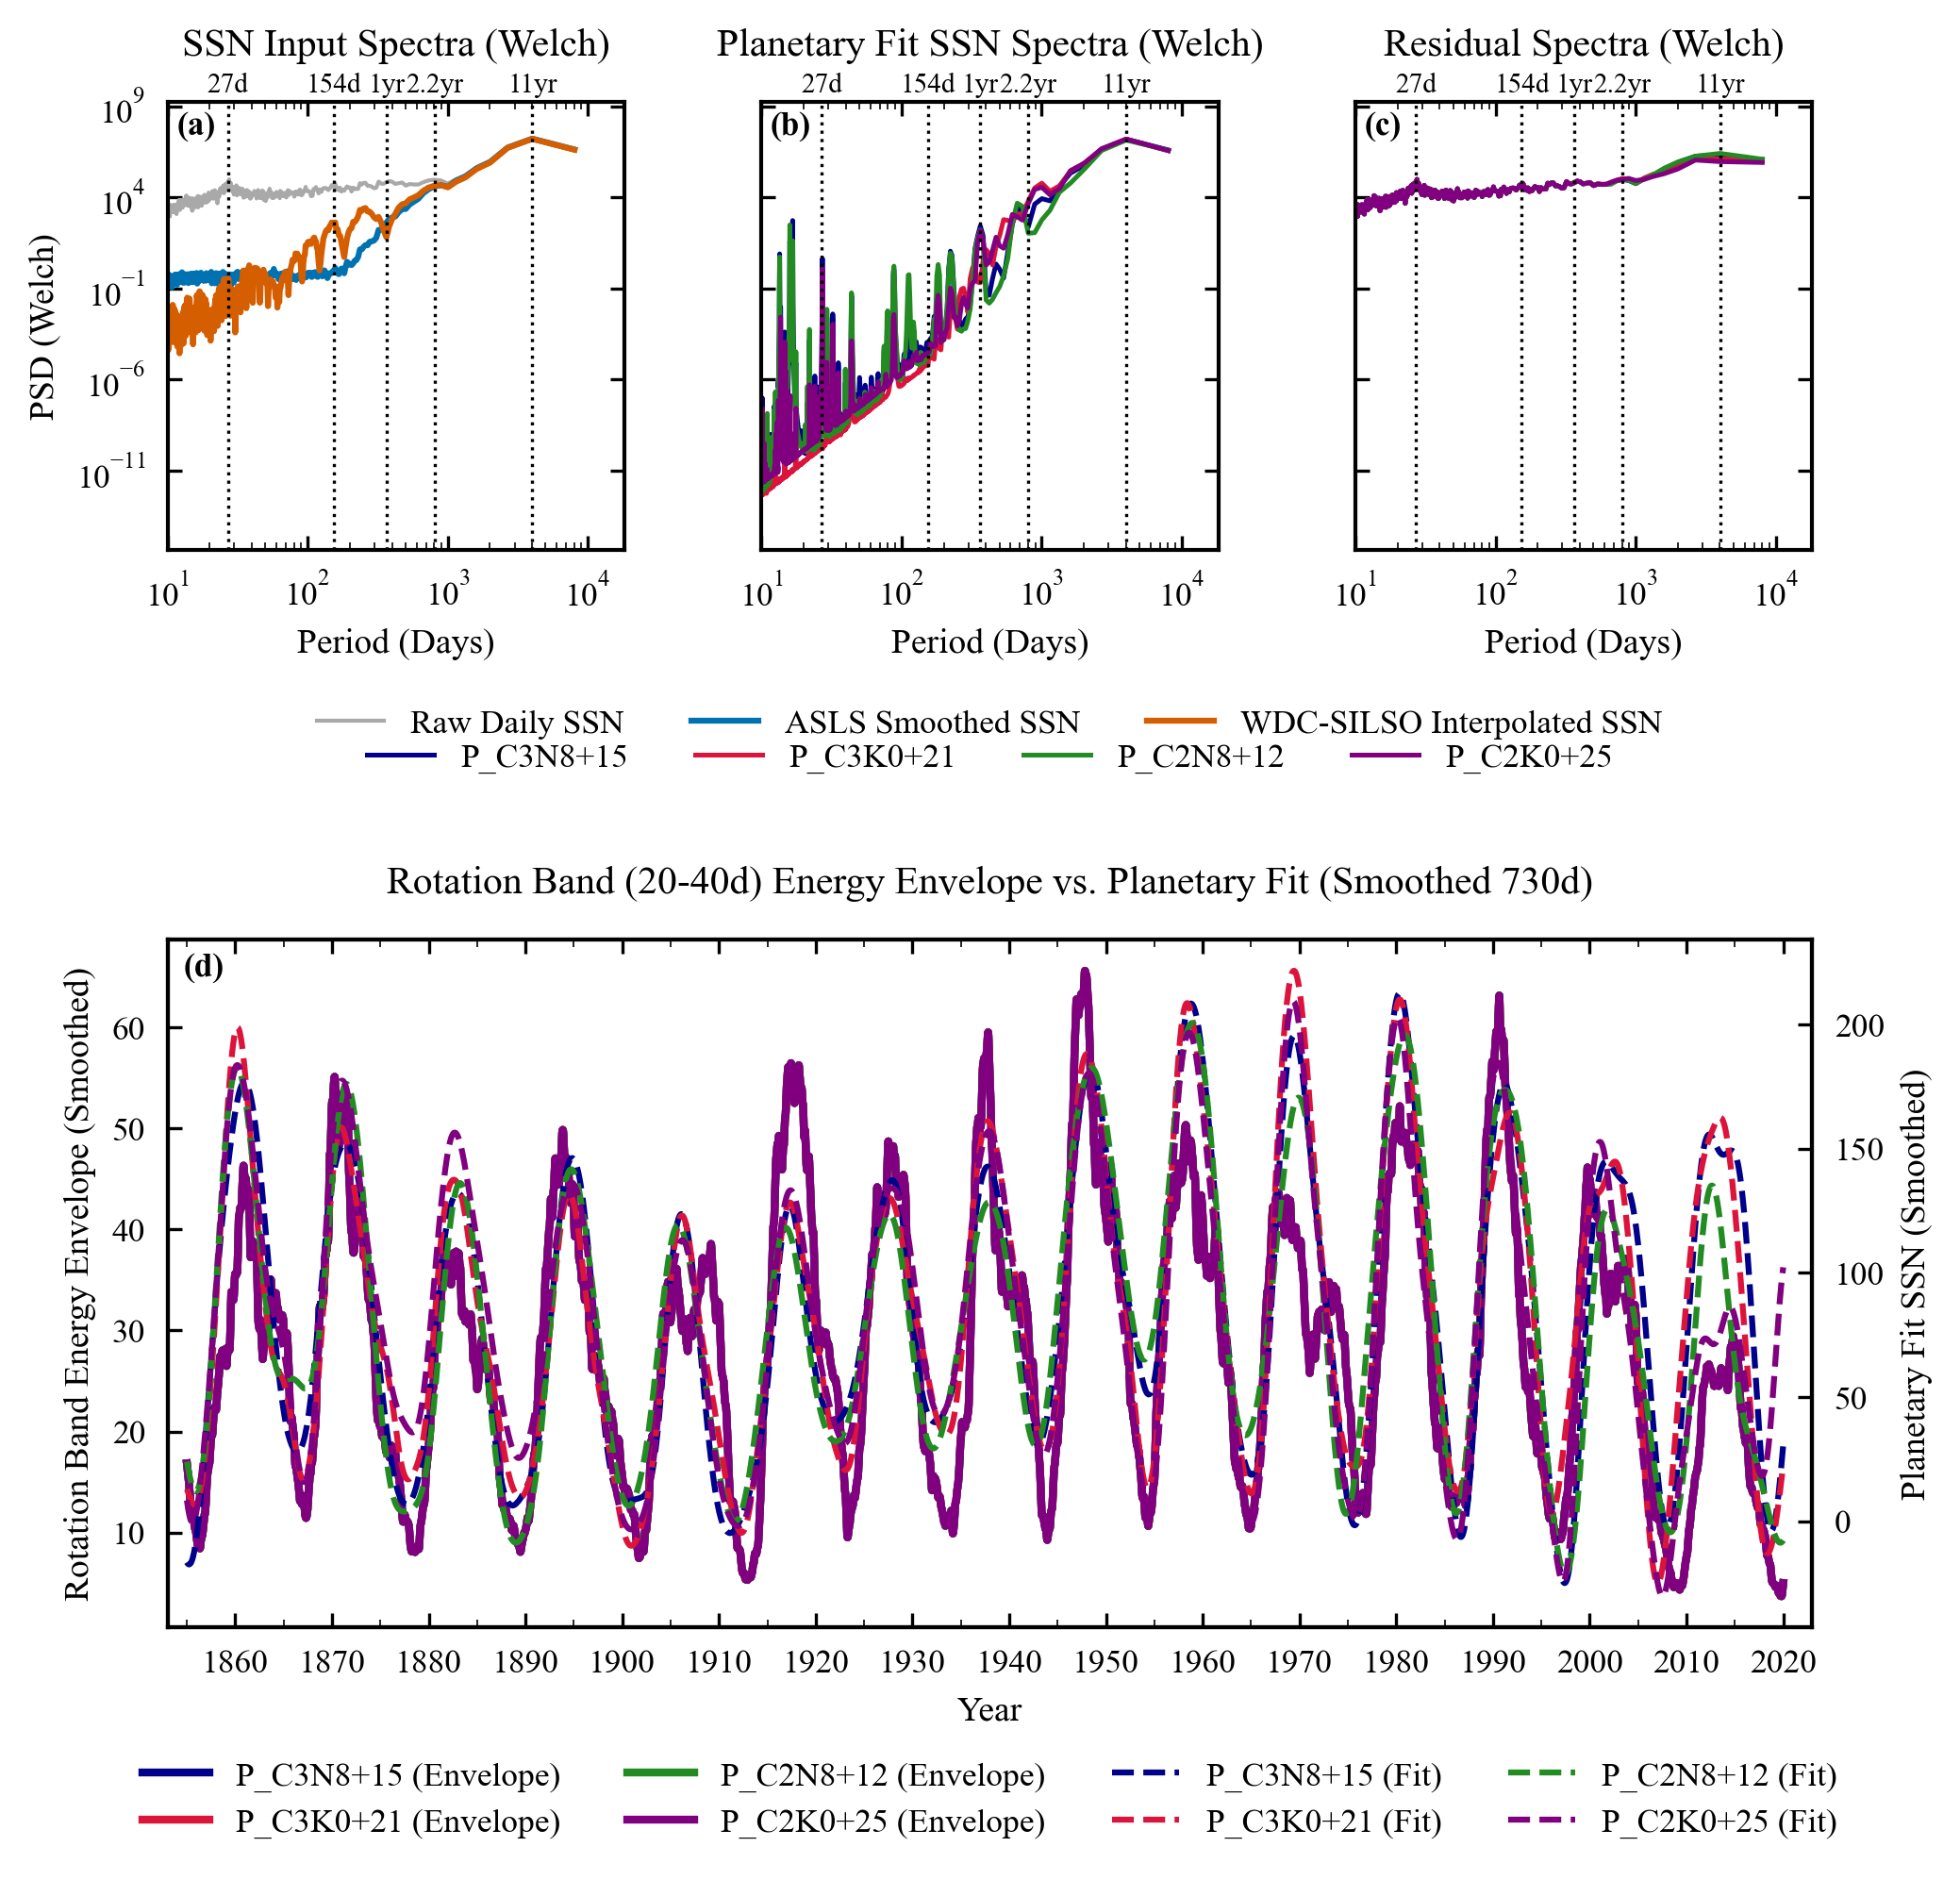

Figure generation process completed.


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
from scipy.signal import welch, butter, sosfiltfilt, hilbert
import warnings
import os
import traceback

# --- 1. Core Helper Functions ---

def setup_astro_style():
    """
    Sets a global Matplotlib style suitable for astronomical academic journals.
    """
    plt.style.use('seaborn-v0_8-paper')
    plt.rcParams.update({
        'font.size': 8.5, 'axes.labelsize': 9, 'axes.titlesize': 10,
        'xtick.labelsize': 8.5, 'ytick.labelsize': 8.5, 'legend.fontsize': 8.5,
        'font.family': 'serif', 'font.serif': ['Times New Roman'], 
        'mathtext.fontset': 'stix', 
        'axes.unicode_minus': False, 
        'xtick.direction': 'in', 'ytick.direction': 'in', 
        'xtick.top': True, 'xtick.bottom': True, 'ytick.left': True, 'ytick.right': True, 
        'axes.linewidth': 1.0, 
        'lines.linewidth': 1.2, 
        'figure.dpi': 300, 
        'savefig.dpi': 300, 
        'savefig.bbox': 'tight',
    })

def calculate_psd_welch(data_series, fs=1.0, nperseg=365*22):
    valid_data_series = data_series.dropna()
    if valid_data_series.empty: return np.array([]), np.array([])
    sig = valid_data_series.values - valid_data_series.mean()
    nperseg = min(nperseg, len(sig))
    if nperseg < 256: pass
    try:
        frequencies, psd = welch(
            sig, fs=fs, nperseg=nperseg, noverlap=nperseg//2,
            detrend='constant', scaling='density'
        )
        valid_mask = frequencies > 0
        if not np.any(valid_mask): return np.array([]), np.array([])
        periods_days = 1 / frequencies[valid_mask]
        power_spectral_density = psd[valid_mask]
        sort_idx = np.argsort(periods_days)
        return periods_days[sort_idx], power_spectral_density[sort_idx]
    except Exception as e:
        print(f"PSD calculation error: {e}")
        return np.array([]), np.array([])

def bandpass_filter(data, lowcut_days, highcut_days, fs=1.0, order=4):
    low_freq = 1.0 / highcut_days
    high_freq = 1.0 / lowcut_days
    nyq = 0.5 * fs 
    low = low_freq / nyq
    high = high_freq / nyq
    low = max(low, 1e-9) 
    high = min(high, 0.9999)
    if low >= high: return data
    try:
        sos = butter(order, [low, high], btype='band', output='sos')
        filtered_data = sosfiltfilt(sos, data)
        return filtered_data
    except Exception as e:
        print(f"Filter error: {e}")
        return data

def get_energy_envelope(data, smoothing_window_days=365):
    try:
        analytic_signal = hilbert(data)
        envelope = np.abs(analytic_signal)
        envelope_series = pd.Series(envelope)
        smoothed_envelope = envelope_series.rolling(
            window=smoothing_window_days, 
            center=True, 
            min_periods=max(1, int(smoothing_window_days * 0.1))
        ).mean()
        return smoothed_envelope.values
    except Exception as e:
        print(f"Energy envelope calculation error: {e}")
        return np.full_like(data, np.nan)

# --- 2. Main Plotting Script ---

def create_analysis_figure(data_file):
    print(f"Starting figure generation, reading data: {data_file}")
    
    setup_astro_style() 
    
    # --- A. Data Loading and Preparation ---
    try:
        # UPDATED: Use 'Date' instead of '日期'
        data = pd.read_csv(data_file, parse_dates=['Date']) 
        data = data.sort_values(by='Date').reset_index(drop=True)
        data_spectrum = data[
            (data['Date'] >= '1855-01-01') & (data['Date'] <= '2025-12-31')
        ].copy()
        print(f"Data loaded successfully.")
        if data_spectrum.empty:
            print("Error: No data found in range 1855-2025.")
            return
    except Exception as e:
        print(f"Error: Unable to read or parse {data_file}. Info: {e}")
        return

    # Model Configuration
    model_config = {
        'model_00_list': ['M8+3', 'M0+3', 'M8+2', 'M0+2'],
        'model_final_names': ['P_C3N8+15', 'P_C3K0+21', 'P_C2N8+12', 'P_C2K0+25'],
        'colors': ['#00008B', '#DC143C', '#228B22', '#800080']
    }
    model_00_list = model_config['model_00_list']
    model_final_names = model_config['model_final_names']
    colors = model_config['colors']
    ssn_colors = ['darkgray', '#0072B2', '#D55E00'] 
    MIN_PERIOD = 10      
    MAX_PERIOD = 365.25 * 50 

    # --- B. Calculate Energy Envelope ---
    print("Calculating energy envelope (20-40 day band)...")
    band_low_days = 20
    band_high_days = 40
    envelope_smoothing_days = 730
    
    for m0 in model_00_list:
        # UPDATED: English column names logic
        resid_col = f'Residual_{m0}' 
        env_col = f'Env_{m0}'   
        
        if resid_col not in data.columns: 
            print(f"Warning: Column {resid_col} not found.")
            continue
            
        try:
            signal_data = data[resid_col].ffill().bfill().fillna(0)
            y_filtered = bandpass_filter(signal_data.values, band_low_days, band_high_days)
            y_envelope = get_energy_envelope(y_filtered, smoothing_window_days=envelope_smoothing_days)
            data[env_col] = y_envelope
        except Exception as e:
            data[env_col] = np.nan
    print("Energy envelope calculation completed.")

    # --- C. Create Figure Layout ---
    fig = plt.figure(figsize=(7.5, 7))
    
    gs = GridSpec(3, 3, 
                  height_ratios=[0.65, 0.1, 1], 
                  hspace=0.4, wspace=0.3,       
                  figure=fig)
    
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1], sharey=ax1) 
    ax3 = fig.add_subplot(gs[0, 2], sharey=ax1) 
    
    legend_ax = fig.add_subplot(gs[1, :]) 
    ax4 = fig.add_subplot(gs[2, :])        

    key_periods = {
        27: '27d', 154: '154d', 365.25: '1yr',
        365.25*2.2: '2.2yr', 365.25*11: '11yr'
    }

    # --- D. Plot Spectra ---
    all_powers = []
    
    # D1: Raw SSN Spectra
    print("Plotting Top-Left (SSN Spectra)...")
    # UPDATED: English column names mapping
    ssn_columns = {
        'Raw_SSN': 'Raw Daily SSN',
        'Smoothed_SSN': 'ASLS Smoothed SSN', 
        'SIDC_SSN': 'WDC-SILSO Interpolated SSN'
    }
    for (col, label), color in zip(ssn_columns.items(), ssn_colors):
        if col in data_spectrum.columns:
            period, power = calculate_psd_welch(data_spectrum[col], nperseg=365*22)
            if len(period) > 0:
                linewidth = 1.0 if col == 'Raw_SSN' else 1.5
                ax1.loglog(period, power, label=label, color=color, linewidth=linewidth)
                all_powers.extend(power)
    
    ax1.set_title('SSN Input Spectra (Welch)', pad=12) 
    ax1.text(0.02, 0.98, '(a)', transform=ax1.transAxes, 
             fontweight='bold', va='top', ha='left')
    
    # D2: Fitted SSN Spectra
    print("Plotting Top-Middle (Fitted SSN Spectra)...")
    for i, (m0, m_name) in enumerate(zip(model_00_list, model_final_names)):
        # UPDATED: English column name
        col = f'Fit_SSN_{m0}' 
        if col in data_spectrum.columns:
            period, power = calculate_psd_welch(data_spectrum[col], nperseg=365*22)
            if len(period) > 0:
                ax2.loglog(period, power, label=m_name, color=colors[i])
                all_powers.extend(power)
    
    ax2.set_title('Planetary Fit SSN Spectra (Welch)', pad=12) 
    ax2.text(0.02, 0.98, '(b)', transform=ax2.transAxes, 
             fontweight='bold', va='top', ha='left')

    # D3: Residual Spectra
    print("Plotting Top-Right (Residual Spectra)...")
    for i, (m0, m_name) in enumerate(zip(model_00_list, model_final_names)):
        # UPDATED: English column name
        col = f'Residual_{m0}' 
        if col in data_spectrum.columns:
            period, power = calculate_psd_welch(data_spectrum[col], nperseg=365*22)
            if len(period) > 0:
                ax3.loglog(period, power, label=m_name, color=colors[i])
                all_powers.extend(power)
    
    ax3.set_title('Residual Spectra (Welch)', pad=12) 
    ax3.text(0.02, 0.98, '(c)', transform=ax3.transAxes, 
             fontweight='bold', va='top', ha='left')
    
    # Format all spectral plots
    if all_powers:
        y_min = np.min(all_powers) * 0.01
        y_max = np.max(all_powers) * 100
    else:
        y_min, y_max = 1e-10, 1e10
    
    for ax in [ax1, ax2, ax3]:
        ax.set_xscale('log') 
        ax.set_yscale('log') 
        ax.set_xlabel('Period (Days)')
        if ax == ax1:
            ax.set_ylabel('PSD (Welch)') 
        ax.set_xlim(MIN_PERIOD, MAX_PERIOD)
        ax.set_ylim(y_min, y_max)
        ax.tick_params(axis='both', which='major')
        ax.tick_params(axis='both', which='minor')
        ax.grid(False) 
        
        trans = ax.get_xaxis_transform() 
        for period, label in key_periods.items():
            if MIN_PERIOD <= period <= MAX_PERIOD:
                ax.axvline(period, color='k', linestyle=':', linewidth=0.8)
                ax.text(period, 1.01, label, 
                        transform=trans,
                        ha='center', va='bottom', rotation=0,
                        fontsize=7)            

    plt.setp(ax2.get_yticklabels(), visible=False)
    plt.setp(ax3.get_yticklabels(), visible=False)

    # D4: Unified Legend
    print("Creating unified top legend...")
    h1, l1 = ax1.get_legend_handles_labels() 
    h2, l2 = ax2.get_legend_handles_labels() 
    
    legend_ax.axis('off') 
    
    leg1 = legend_ax.legend(h1, l1, loc='center', ncol=3, 
                            frameon=False, 
                            bbox_to_anchor=(0.5, 0.8))
    
    leg2 = legend_ax.legend(h2, l2, loc='center', ncol=4,
                            frameon=False, 
                            bbox_to_anchor=(0.5, 0.3))
    
    legend_ax.add_artist(leg1) 

    # --- E. Plot Energy Envelope ---
    print("Plotting Bottom (Energy Envelope)...")
    ax4_twin = ax4.twinx() 
    env_linewidth = 2.0  
    fit_linewidth = 1.5  
    plot_mask = (data['Date'] >= '1855-01-01') & (data['Date'] <= '2019-12-31')
    plot_dates = data.loc[plot_mask, 'Date']
    
    for i, (m0, m_name) in enumerate(zip(model_00_list, model_final_names)):
        env_col = f'Env_{m0}'
        # UPDATED: English column name
        fit_col = f'Fit_SSN_{m0}' 
        
        if env_col in data.columns:
            plot_env_data = data.loc[plot_mask, env_col]
            line = ax4.plot(plot_dates, plot_env_data, color=colors[i], linestyle='-', 
                            label=f'{m_name} (Envelope)', linewidth=env_linewidth)
            line[0].set_alpha(1.0)
            
        if fit_col in data.columns:
            smoothed_fit_all = data[fit_col].rolling(
                window=envelope_smoothing_days, center=True, 
                min_periods=max(1, int(envelope_smoothing_days * 0.1))
            ).mean()
            plot_fit_data = smoothed_fit_all[plot_mask] 
            line = ax4_twin.plot(plot_dates, plot_fit_data, color=colors[i], linestyle='--', 
                                 label=f'{m_name} (Fit)', linewidth=fit_linewidth)
            line[0].set_alpha(1.0)
            
    ax4.set_title(f'Rotation Band (20-40d) Energy Envelope vs. Planetary Fit (Smoothed {envelope_smoothing_days}d)', pad=12) 
    ax4.text(0.01, 0.98, '(d)', transform=ax4.transAxes,
             fontweight='bold', va='top', ha='left')
    ax4.set_xlabel('Year')
    ax4.set_ylabel('Rotation Band Energy Envelope (Smoothed)')
    ax4_twin.set_ylabel('Planetary Fit SSN (Smoothed)')
    
    plot_start_date = pd.to_datetime('1853-01-01')
    plot_end_date = pd.to_datetime('2022-12-31')
    ax4.set_xlim(plot_start_date, plot_end_date)
    ax4.xaxis.set_major_locator(mdates.YearLocator(10))
    ax4.xaxis.set_minor_locator(mdates.YearLocator(5))
    ax4.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    lines, labels = ax4.get_legend_handles_labels()
    lines_twin, labels_twin = ax4_twin.get_legend_handles_labels()
    
    ax4.legend(lines + lines_twin, labels + labels_twin, 
               loc='upper center', bbox_to_anchor=(0.5, -0.15), 
               ncol=4, frameon=False) 

    # --- F. Save Figure ---
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        fig.tight_layout(rect=[0, 0.05, 1, 0.95]) 
    
    output_basename = "../../results/05_p_m_a_model/Fig07_residual_analysis_Welch"
    output_filename_eps = f"{output_basename}.eps"
    
    try:
        for ax in [ax1, ax2, ax3, ax4, ax4_twin]:
            ax.patch.set_alpha(1.0)
            for line in ax.get_lines():
                line.set_alpha(1.0)
            for text in ax.texts:
                text.set_alpha(1.0)
        
        plt.savefig(output_filename_eps, 
                    format='eps', 
                    bbox_inches='tight', 
                    dpi=300)
        print(f"EPS plotting finished! Saved to: {output_filename_eps}")
        
    except Exception as e:
        print(f"Failed to save EPS: {e}")
            
    plt.show()
    print("Figure generation process completed.")

if __name__ == "__main__":
    # UPDATED: File path
    DATA_FILE = "../../results/05_p_m_a_model/a_model_4/LSTM_Full_Results_SEQLEN400_20251229_221056.csv"
    
    if not os.path.exists(DATA_FILE):
        print(f"Error: Data file not found {DATA_FILE}")
    else:
        try:
            create_analysis_figure(DATA_FILE)
        except Exception as e:
            print(f"Error: Unexpected error during generation: {e}")
            traceback.print_exc()